In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
cities = ['ABZ', 'ALE', 'AMA', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'DEL', 'EGB',
          'FKL', 'HAD', 'HEL', 'HPB', 'HRW', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 
          'MLP', 'MUK', 'NAN', 'NEU', 'POV', 'PRL', 'SAO', 'SCH', 'SGP', 'UAE',
          'VAR', 'VHL', 'VIE', 'WAL', 'ZOT']

variables = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
             'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11', 'co', 'c5h8', 'c10h16', 
             'nh3', 'no', 'no2', 'so2', 'd2m', 't2m', 'crwc', 'blh', 'rh', 
             'doy_sin', 'doy_cos', 'latitude', 'longitude_sin', 'longitude_cos']

dont_transform = ['d2m', 't2m', 'blh', 'rh', 'doy_sin', 'doy_cos', 
                  'latitude', 'longitude_sin', 'longitude_cos']

transf_vars = []
for v in variables:    
    if v in dont_transform:
        transf_vars.append(v)
    else:
        transf_vars.append(v+'_log')

In [18]:
# loading the data
data = pd.read_csv('data/full_data.csv', parse_dates=['date'])

# log-transformed values that are < 1 become negative, which doesn't make sense
data.loc[data.n100 < 1, 'n100'] = 1

# log-transforming selected variables
for v in ['n100']+variables:
    if v not in dont_transform:
        transformed = data[v]
        transformed = transformed.where(transformed > 0, transformed[transformed > 0].min())
        data[v+'_log'] = np.log(transformed)
        
data.head()

,id,station,date,doy_sin,doy_cos,latitude,longitude_sin,longitude_cos,n100,aermr01,...,aermr10_log,aermr11_log,co_log,c5h8_log,c10h16_log,nh3_log,no_log,no2_log,so2_log,crwc_log
0,ABZ-2012-01-26,ABZ,2012-01-26,0.431673,0.902030,0.561889,0.438057,0.898947,2708.085714,6.752697e-12,...,-21.309149,-21.085343,-14.888857,-24.715712,-22.277308,-20.891909,-18.156078,-17.697916,-18.856889,-24.916861
1,ABZ-2012-01-27,ABZ,2012-01-27,0.447094,0.894487,0.561889,0.438057,0.898947,2489.175000,4.223335e-12,...,-21.181645,-21.136839,-14.786466,-24.526129,-22.109902,-20.714570,-18.022533,-17.632291,-18.761336,-24.916861
2,ABZ-2012-01-28,ABZ,2012-01-28,0.462383,0.886680,0.561889,0.438057,0.898947,3484.229167,3.553853e-12,...,-20.943542,-20.573239,-14.472229,-24.080899,-21.518834,-20.381543,-17.223582,-17.785600,-18.708921,-24.916861
3,ABZ-2012-01-29,ABZ,2012-01-29,0.477536,0.878612,0.561889,0.438057,0.898947,2977.512500,8.665312e-12,...,-21.326093,-19.603823,-14.977114,-25.068593,-22.885339,-20.340459,-19.236020,-17.969860,-19.128033,-24.916861
4,ABZ-2012-01-30,ABZ,2012-01-30,0.492548,0.870285,0.561889,0.438057,0.898947,2702.463636,1.436837e-11,...,-21.669206,-19.666249,-15.236442,-25.461374,-23.836271,-20.333199,-20.702253,-18.124264,-19.070916,-24.916861


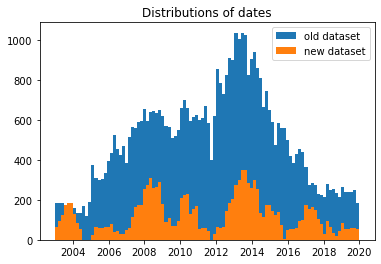

In [19]:
date_ranges = pd.read_csv('metadata/date_ranges_of_stations.csv', parse_dates=['start_date', 'end_date'], dayfirst=True)
date_ranges.head()

new_data = []

for c in cities:
    sd = date_ranges.start_date.loc[date_ranges.station == c].iloc[0]
    ed = date_ranges.end_date.loc[date_ranges.station == c].iloc[0]
    c_data = data.loc[data.station == c]
    c_data = c_data.loc[c_data.date >= sd]
    c_data = c_data.loc[c_data.date <= ed]
    new_data.append(c_data)

new_data = pd.concat(new_data)
new_data = new_data.reset_index(drop=True)

plt.hist(data.date, bins=100, label='old dataset')
plt.hist(new_data.date, bins=100, label='new dataset')
plt.title('Distributions of dates')
plt.legend()

data = new_data

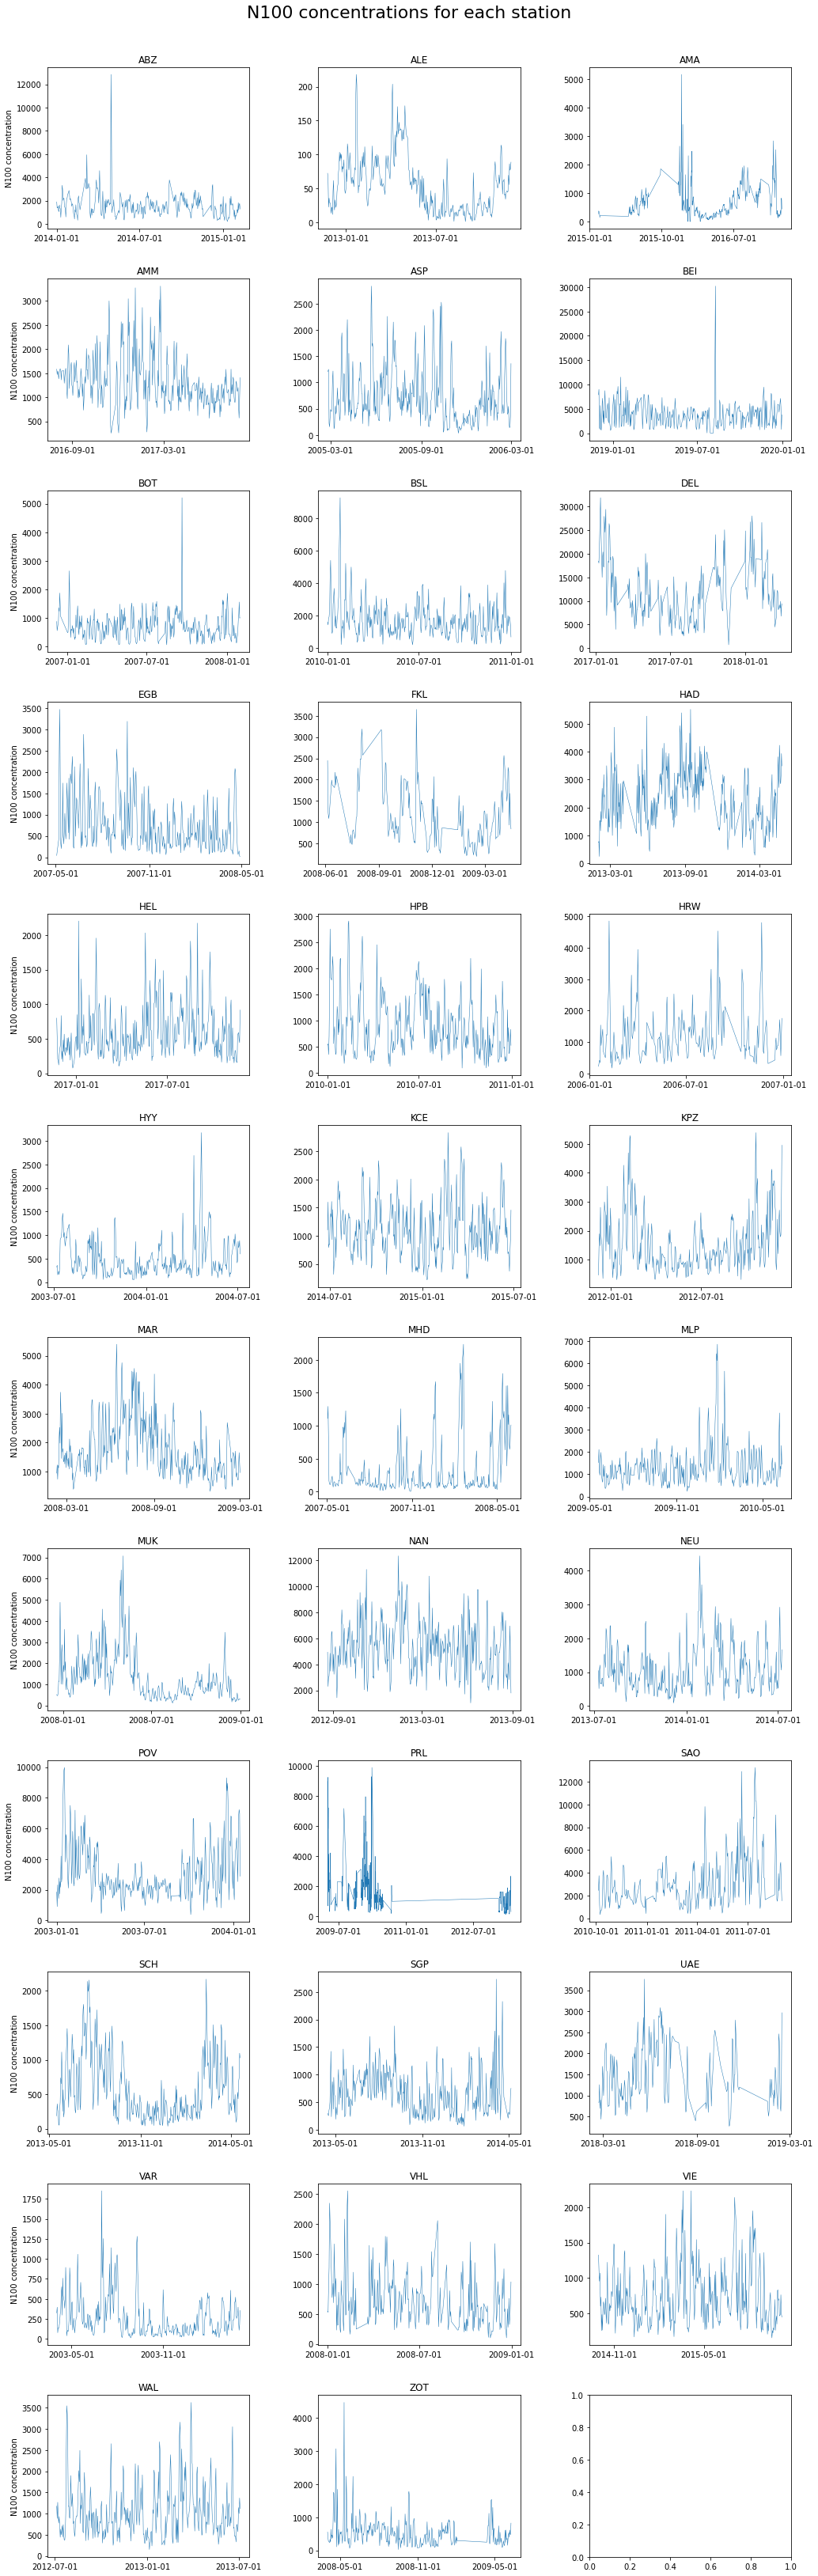

In [20]:
fig, axes = plt.subplots(12, 3, figsize=(15,45))
axes = iter(axes)
i = 0

for c in cities:
    if i%3 == 0:
        axis = next(axes)
    ax = axis[i%3]
    ax.plot(data.date.loc[data.station == c], data.n100.loc[data.station == c], lw=0.5)
    ax.set_title(c)
    ax.set_xticks(ax.get_xticks()[::3])
    if i%3 == 0:
        ax.set_ylabel('N100 concentration')
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('N100 concentrations for each station', y=1.01, fontsize=22);

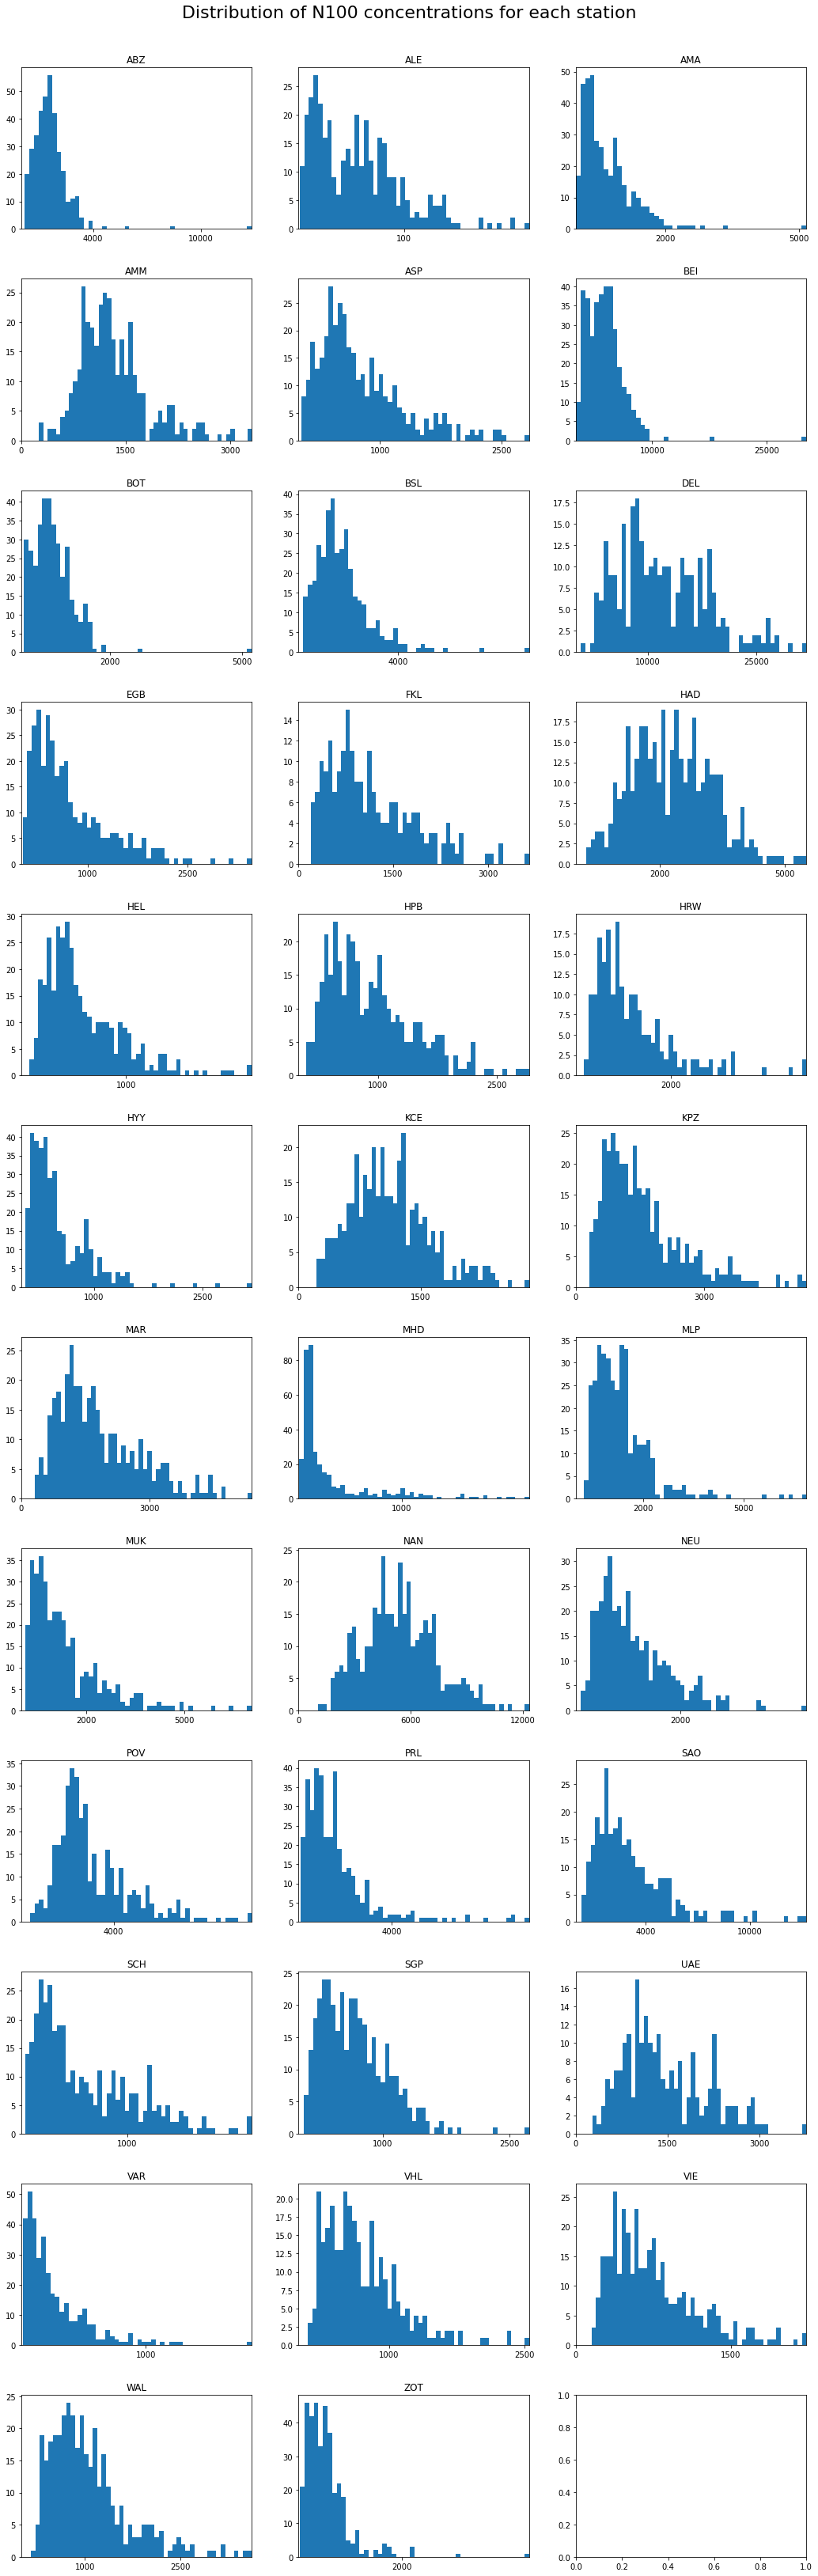

In [21]:
fig, axes = plt.subplots(12, 3, figsize=(15, 45))
axes = iter(axes)
i = 0

for c in cities:
    if i%3 == 0:
        axis = next(axes)
    ax = axis[i%3]
    ax.hist(data.n100.loc[data.station == c], bins=50)
    ax.set_title(c)
    ax.set_xticks(ax.get_xticks()[::3])
    ax.set_xlim(0, max(data.n100.loc[data.station == c]))
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('Distribution of N100 concentrations for each station', y=1.01, fontsize=22);

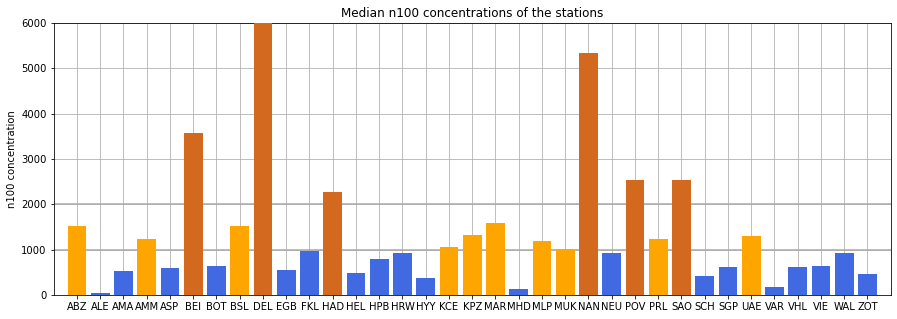

In [22]:
n100_medians = []

for s, group in data.groupby('station'):
    n100_medians.append(group.n100.median())
    
n100_medians_groups = np.where(np.array(n100_medians) > 1000, 'medium', 'low')
n100_medians_groups = np.where(np.array(n100_medians) > 2000, 'high', n100_medians_groups)

n100_medians_colors = list(map(lambda x: {'high':'chocolate', 'medium':'orange', 'low':'royalblue'}[x], 
                             n100_medians_groups))

plt.figure(figsize=(15,5))
plt.bar(cities, n100_medians, zorder=3, color=n100_medians_colors)
plt.grid(zorder=1)
plt.hlines([1000, 2000], xmin=-2, xmax=len(cities)+1, zorder=2, color='darkgrey')
plt.title('Median n100 concentrations of the stations')
plt.ylabel('n100 concentration')
plt.ylim(0, 6000)
plt.xlim(-1, len(cities));

In [23]:
variable_dict = {'n100': 'N100 concentration',
                 'aermr01': 'Sea salt aerosol (0.03 - 0.5 µm)\nmixing ratio',
                 'aermr02': 'Sea salt aerosol (0.5 - 5 µm)\nmixing ratio',
                 'aermr03': 'Sea salt aerosol (5 - 20 µm)\nmixing ratio',
                 'aermr04': 'Dust aerosol (0.03 - 0.55 µm)\nmixing ratio',
                 'aermr05': 'Dust aerosol (0.55 - 0.9 µm)\nmixing ratio',
                 'aermr06': 'Dust aerosol (0.9 - 20 µm)\nmixing ratio',
                 'aermr07': 'Hydrophilic organic matter\naerosol mixing ratio',
                 'aermr08': 'Hydrophobic organic matter\naerosol mixing ratio',                 
                 'aermr09': 'Hydrophilic black carbon\naerosol mixing ratio',
                 'aermr10': 'Hydrophobic black carbon\naerosol mixing ratio',
                 'aermr11': 'Sulphate aerosol mixing ratio',
                 'co': 'Carbon monoxide',
                 'c5h8': 'Isoprene',
                 'c10h16': 'Terpenes',
                 'nh3': 'Ammonia',
                 'no': 'Nitrogen monoxide',
                 'no2': 'Nitrogen dioxide',
                 'so2': 'Sulphur dioxide',
                 'd2m': 'Dew point temperature\nat 2m height',
                 't2m': 'Air temperature\nat 2m height',
                 'crwc': 'Specific rain water content',
                 'blh': 'Boundary layer height',
                 'rh': 'Relative humidity',
                 'doy_sin': 'Sine of the day of the year',
                 'doy_cos': 'Cosine of the day of the year',
                 'latitude': 'Latitude',
                 'longitude_sin': 'Sine of longitude',
                 'longitude_cos': 'Cosine of longitude'}

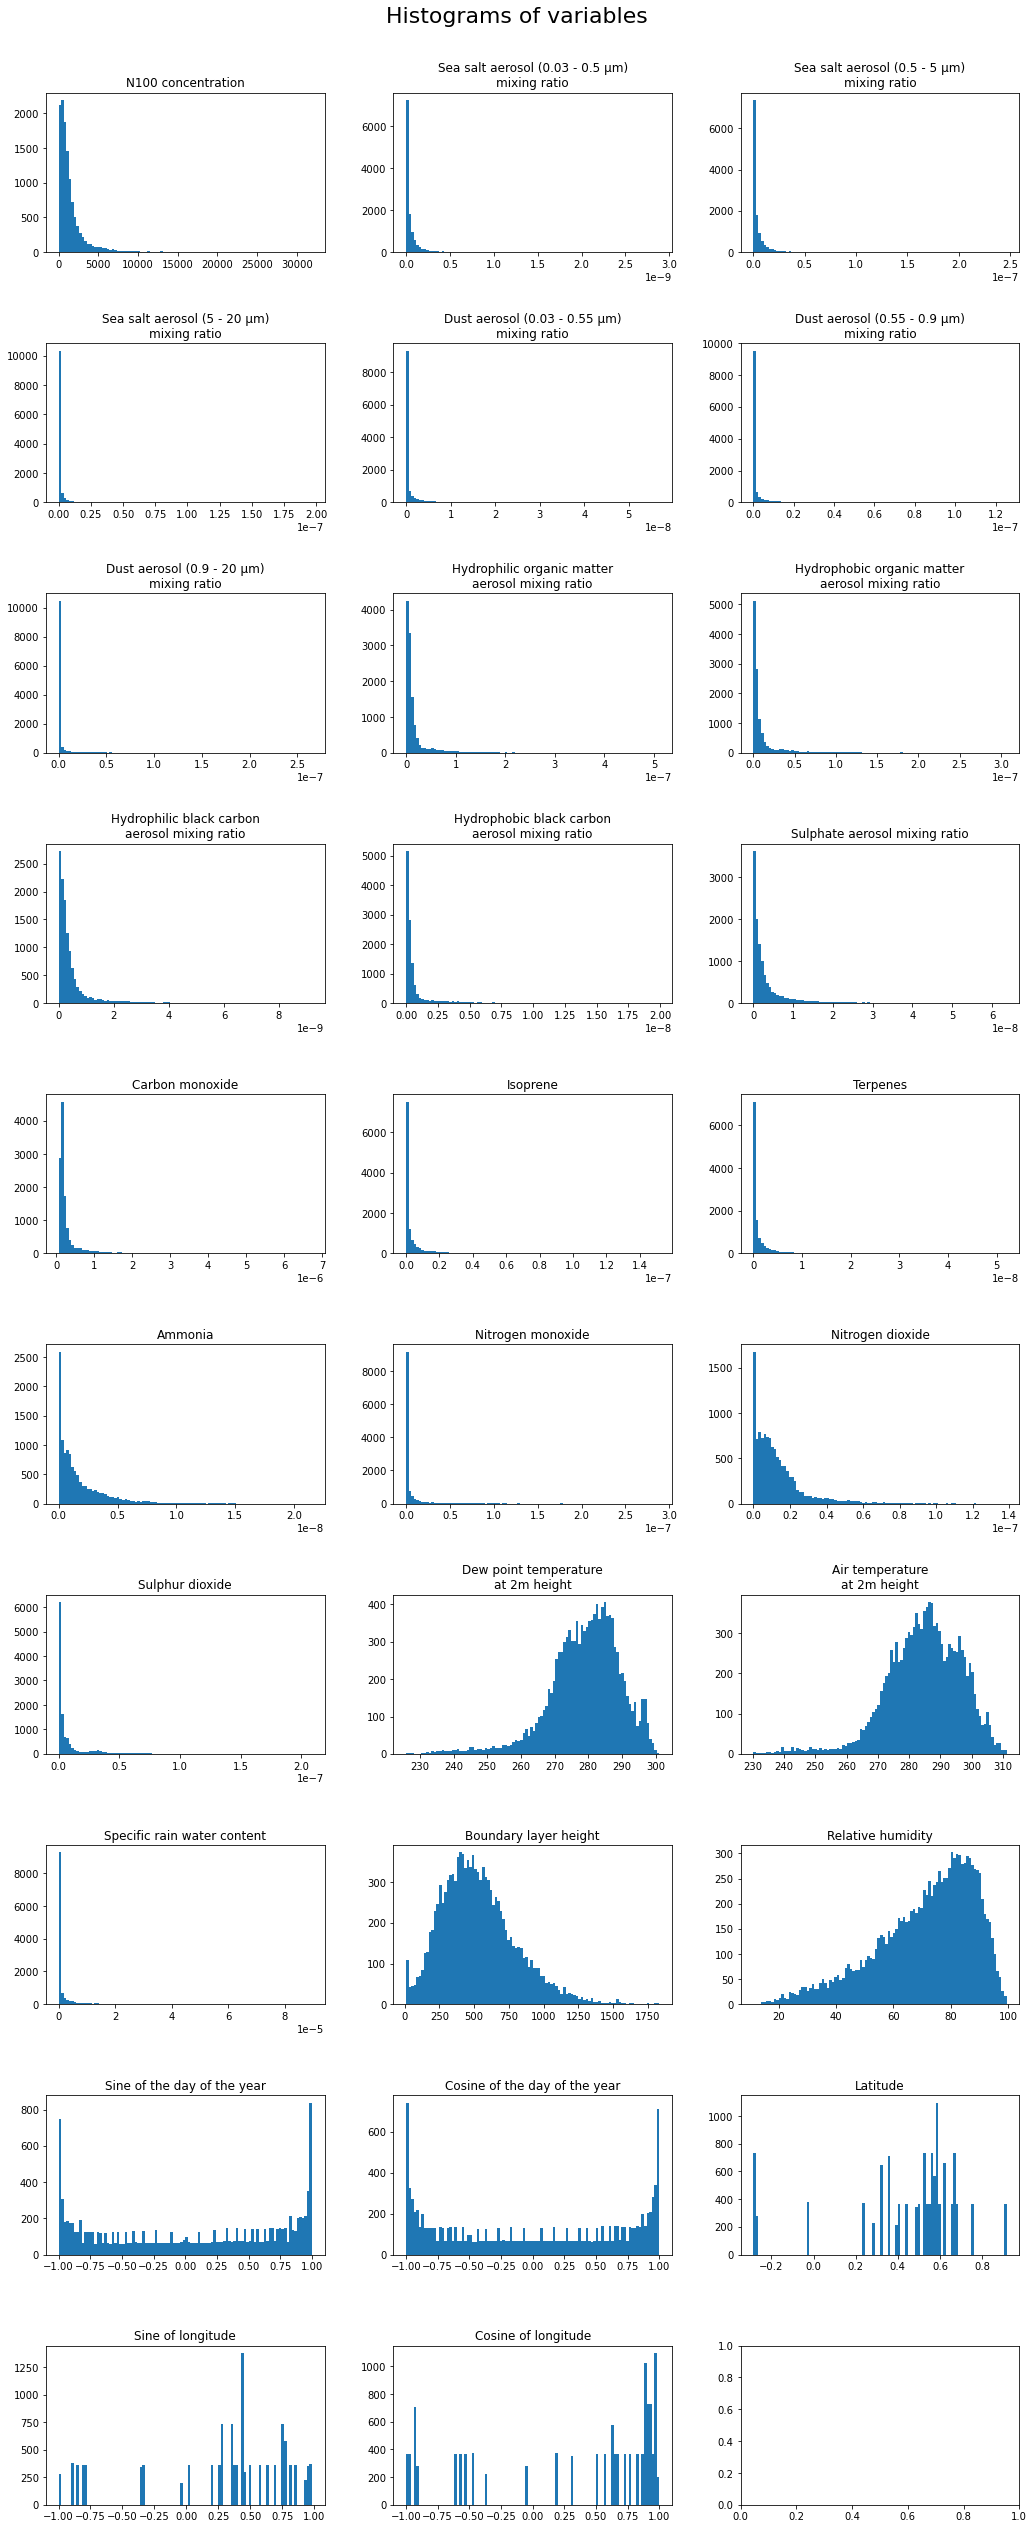

In [24]:
ncols = 3
fig, axes = plt.subplots(10, ncols, figsize=(15, 35))
axes = iter(axes)
i = 0

for v in ['n100']+variables:
    if i%ncols == 0:
        axis = next(axes)
    ax = axis[i%ncols]
    ax.hist(data[v], bins=100)
    ax.set_title(variable_dict[v])
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('Histograms of variables', y=1.01, fontsize=22);

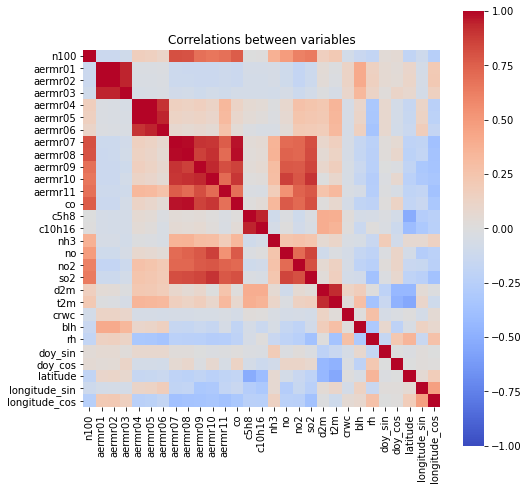

In [25]:
plt.figure(figsize=(8, 8))
sns.heatmap(data[['n100']+variables].corr(), 
            xticklabels=['n100']+variables, yticklabels=['n100']+variables, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1)
plt.title('Correlations between variables');

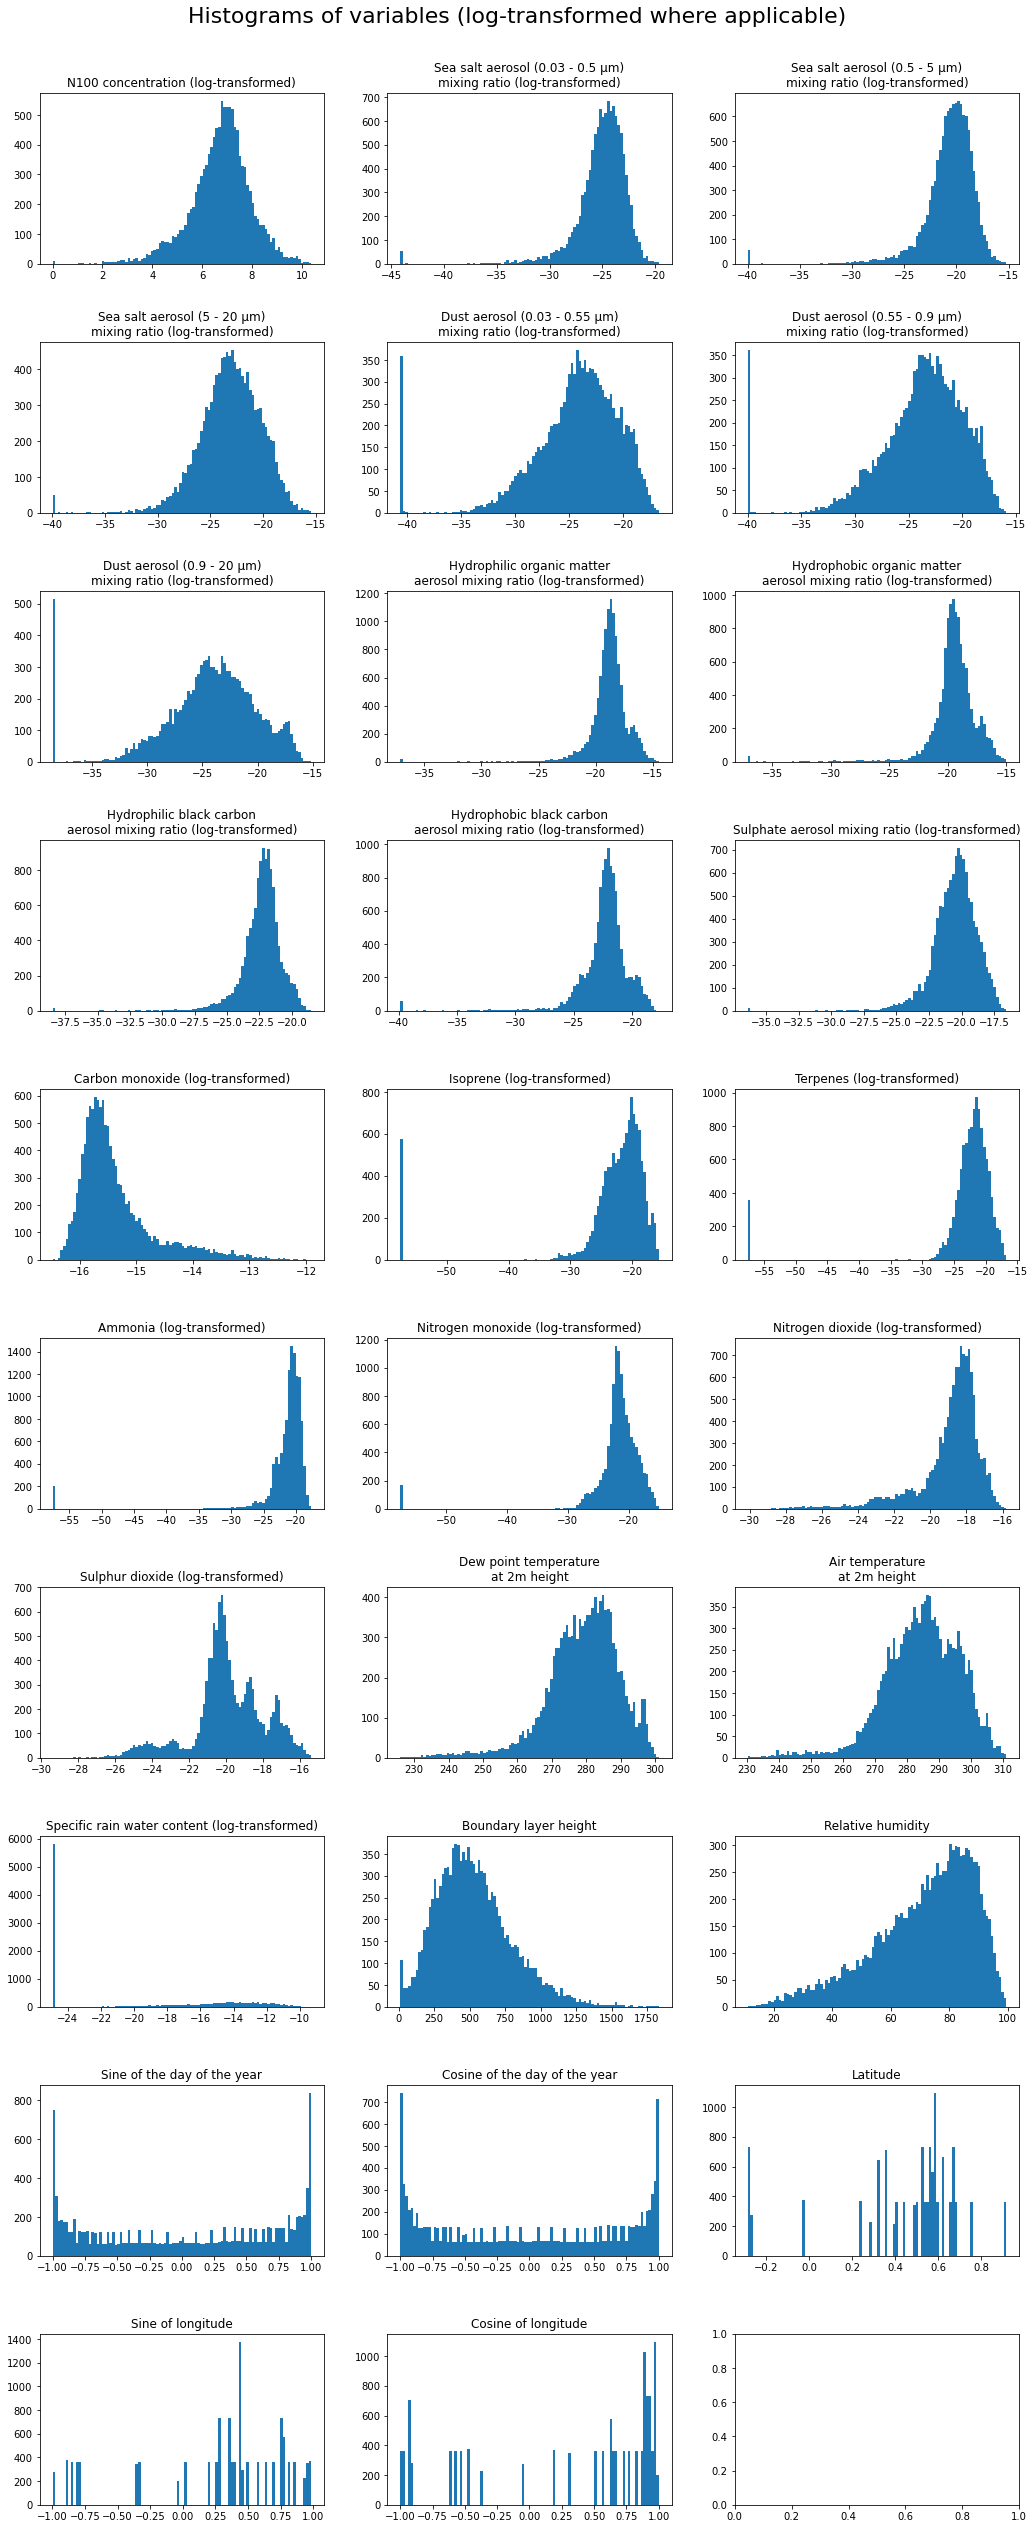

In [26]:
ncols = 3
fig, axes = plt.subplots(10, ncols, figsize=(15, 35))
axes = iter(axes)
i = 0

for v in ['n100_log']+transf_vars:
    if i%ncols == 0:
        axis = next(axes)
    ax = axis[i%ncols]
    ax.hist(data[v], bins=100)
    if v[-3:] == 'log':
        ax.set_title(variable_dict[v[:-4]] +' (log-transformed)')
    else:
        ax.set_title(variable_dict[v])
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('Histograms of variables (log-transformed where applicable)', y=1.01, fontsize=22);

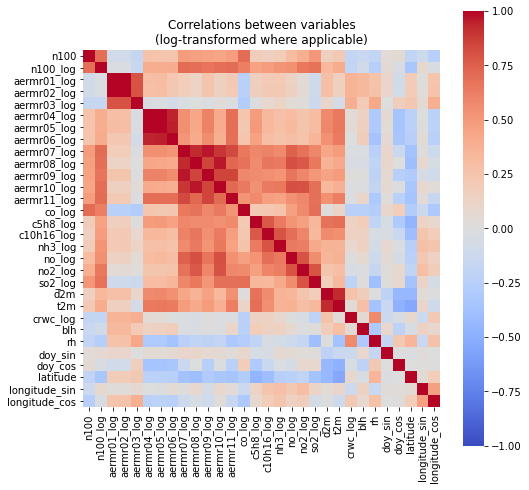

In [27]:
plt.figure(figsize=(8, 8))        
sns.heatmap(data[['n100', 'n100_log']+transf_vars].corr(), 
            xticklabels=['n100', 'n100_log']+transf_vars, yticklabels=['n100', 'n100_log']+transf_vars, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1)
plt.title('Correlations between variables\n(log-transformed where applicable)');

In [28]:
print('Strongest correlations of variables with N100 (before and after log-transforming):')

for v in variables:
    corr = np.round(pearsonr(data[v], data.n100), 3)
    extra_space = int(corr[0] >= 0)
    offset = 14 - len(v) + extra_space
    
    if v+'_log' in data.columns:
        transf_corr = np.round(pearsonr(data[v+'_log'], data.n100), 3)
        if np.abs(transf_corr[0]) > np.abs(corr[0]):
            print(v, ' '*offset, corr[0], '\t', ' '*extra_space, transf_corr[0], 
                  ' \tcorr higher with transformed data')
        else:
            print(v, ' '*offset, corr[0], '\t', ' '*extra_space, transf_corr[0])
    else:
        print(v, ' '*offset, corr[0])

Strongest correlations of variables with N100 (before and after log-transforming):
aermr01         -0.128 	  -0.086
aermr02         -0.129 	  -0.089
aermr03         -0.097 	  -0.158  	corr higher with transformed data
aermr04          0.166 	   0.26  	corr higher with transformed data
aermr05          0.15 	   0.254  	corr higher with transformed data
aermr06          0.114 	   0.258  	corr higher with transformed data
aermr07          0.808 	   0.492
aermr08          0.8 	   0.467
aermr09          0.684 	   0.457
aermr10          0.662 	   0.441
aermr11          0.68 	   0.484
co               0.759 	   0.697
c5h8            -0.004 	  0.178  	corr higher with transformed data
c10h16           0.007 	   0.159  	corr higher with transformed data
nh3              0.37 	   0.191
no               0.485 	   0.309
no2              0.612 	   0.385
so2              0.634 	   0.512
d2m              0.16
t2m              0.216
crwc            -0.082 	  -0.178  	corr higher with transformed data


In [29]:
print('Strongest correlations of variables with log-transformed N100 (before and after log-transforming):')

for v in variables:
    corr = np.round(pearsonr(data[v], data.n100_log), 3)
    extra_space = int(corr[0] >= 0)
    offset = 14 - len(v) + extra_space
    
    if v+'_log' in data.columns:
        transf_corr = np.round(pearsonr(data[v+'_log'], data.n100_log), 3)
        if np.abs(transf_corr[0]) > np.abs(corr[0]):
            print(v, ' '*offset, corr[0], '\t', ' '*extra_space, transf_corr[0], 
                  ' \tcorr higher with transformed data')
        else:
            print(v, ' '*offset, corr[0], '\t', ' '*extra_space, transf_corr[0])
    else:
        print(v, ' '*offset, corr[0])

Strongest correlations of variables with log-transformed N100 (before and after log-transforming):
aermr01         -0.217 	  -0.03
aermr02         -0.219 	  -0.029
aermr03         -0.202 	  -0.149
aermr04          0.205 	   0.396  	corr higher with transformed data
aermr05          0.196 	   0.394  	corr higher with transformed data
aermr06          0.176 	   0.401  	corr higher with transformed data
aermr07          0.523 	   0.697  	corr higher with transformed data
aermr08          0.508 	   0.694  	corr higher with transformed data
aermr09          0.537 	   0.67  	corr higher with transformed data
aermr10          0.498 	   0.689  	corr higher with transformed data
aermr11          0.552 	   0.698  	corr higher with transformed data
co               0.48 	   0.624  	corr higher with transformed data
c5h8             0.02 	   0.458  	corr higher with transformed data
c10h16           0.032 	   0.481  	corr higher with transformed data
nh3              0.394 	   0.527  	corr higher 